In [1]:
import glob
import pickle
import numpy as np
import xarray as xr
from munkres import Munkres
from datetime import datetime
import matplotlib.pyplot as plt
import plotly.express as px

import plotly.graph_objects as go

from scipy.sparse import csr_matrix, save_npz
from scipy.ndimage import label, find_objects


### Establish paths, load original data

In [2]:
real = 'real'
model_loc = "/glade/work/schreck/repos/HOLO/dev/holodec-ml/results/manopt/"
model_save = "/glade/scratch/ggantos/holodec/models/manopt/"


In [3]:
try:
    h_idx_indices = list(set(sorted([int(x.split("_")[1]) for x in glob.glob(f"{model_loc}/{real}/propagated/true*")])))
except:
    h_idx_indices = list(set(sorted([int(x.split("_")[2]) for x in glob.glob(f"{model_loc}/{real}/propagated/true*")])))
print(f"h_idx_indices: {h_idx_indices}")


h_idx_indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


In [4]:
try:
    z_file_indices = list(np.load(f"{model_save}inference/z_indices.npy"))
    print(f"z_file_indices from file {model_save}inference/z_indices.npy range from {min(z_file_indices)} to {max(z_file_indices)}.")
except:
    z_file_indices = sorted([int(x.replace(".npz", "").split("_")[-1]) for x in glob.glob(f"{model_loc}/{real}/propagated/true_{h_idx_indices[0]}_*")])
    print(f"z_file_indices range from {min(z_file_indices)} to {max(z_file_indices)}.")


z_file_indices range from 14072 to 157928.


In [5]:
if 'real' in real:
    print("real")
    ds = xr.open_dataset("/glade/p/cisl/aiml/ai4ess_hackathon/holodec/real_holograms_CSET_RF07_20150719_200000-210000.nc")
else:
    ds = xr.open_dataset("/glade/p/cisl/aiml/ai4ess_hackathon/holodec/synthetic_holograms_500particle_gamma_4872x3248_test.nc")
dx = ds.attrs['dx']      # horizontal resolution
dy = ds.attrs['dy']      # vertical resolution


real


### Create SciPy Objects


In [ ]:
def load_sparse_csr(filename):
    # here we need to add .npz extension manually
    loader = np.load(filename + '.npz')
    return csr_matrix((loader['data'], loader['indices'], loader['indptr']),
                      shape=loader['shape'])


In [ ]:
# Create scipy objects
for h_idx in h_idx_indices:
    for true in ['true', 'pred']:
        start_3d = datetime.now()
        array3d = []
        for z_file in z_file_indices:
            try:
                array2d = load_sparse_csr(f"{model_loc}/{real}/propagated/{true}_{h_idx}_{z_file}").toarray()
                array3d.append(array2d)
            except:
                array2d = np.zeros((4872, 3248))
                array3d.append(array2d)
        array3d = np.stack(array3d)
        print(array3d.shape)
        print(f"Loading 3D {true} took {datetime.now() - start_3d} time")
        print(f"\th_idx {h_idx} has {np.sum(array3d)} non-zero values")
        
        start_label = datetime.now()
        labeled_array, num_features = label(array3d, structure=None)
#         np.save(f"{model_save}inference/{real}/num_features_{true}_{h_idx}", num_features)
#         np.save(f"{model_save}inference/{real}/labeled_array_{true}_{h_idx}", labeled_array)
        print(f"Number of features found from {true} masks is {num_features}.")
        print(f"Shape of labeled_array_{true} {labeled_array.shape}.")
        print(f"Scipy label for {true}_3D took {datetime.now() - start_label} time")

        start_fo = datetime.now()
        objects = find_objects(labeled_array)
        np.save(f"{model_save}inference/{real}/objects_{true}_{h_idx}", objects)
        print(f"Scipy find_objects for {true}_3D took {datetime.now() - start_fo} time\n")
del array2d, array3d, labeled_array, num_features, objects
gc.collect()

### Load all hologram data (predicted, true, and original) into one dictionary

* predicted: model output
* true: model masks input as target variable and processed with scipy label & find_objects
* original: original data without scipy or model interference

In [6]:
particles= {}

for h_idx in h_idx_indices:
    
    particles[h_idx] = {}
    particles[h_idx]['orig'] = {}
    
    particle_idx = np.where(ds['hid'].values==h_idx+1)
    particles[h_idx]['orig']['x'] = ds['x'].values[particle_idx]
    particles[h_idx]['orig']['y'] = ds['y'].values[particle_idx]
    particles[h_idx]['orig']['z'] = ds['z'].values[particle_idx]
    particles[h_idx]['orig']['d'] = ds['d'].values[particle_idx]
    
    for true in ('true', 'pred'):
        
        particles[h_idx][true] = {}

        objects = np.load(f"{model_save}inference/{real}/objects_{true}_{h_idx}.npy", allow_pickle=True)
        if objects.shape[0] == 0:
            print(f"Removing h_idx {h_idx} from h_idx_indices: {model_save}inference/{real}/objects_{true}_{h_idx}.npy empty")
            h_idx_indices = list(set(h_idx_indices)^set([h_idx]))
            particles.pop(h_idx, None)
        else:
            x = []
            y = []
            z = []
            d = []
            for obj in objects:
                x.append(int((obj[1].stop + obj[1].start)/2))
                y.append(int((obj[2].stop + obj[2].start)/2))
                z.append(z_file_indices[int((obj[0].stop + obj[0].start)/2)])

                d_x = (obj[1].indices(10000)[1] - obj[1].indices(10000)[0]) * dx
                d_y = (obj[2].indices(10000)[1] - obj[2].indices(10000)[0]) * dy
                d.append((d_x + d_y) / 2 / 1e-6)

            particles[h_idx][true]['z'] = np.array(z)
            x = np.array(x) * dx * 1e6
            particles[h_idx][true]['x'] = x - (np.max(x) - np.min(x)) / 2
            y = np.array(y) * dy * 1e6
            particles[h_idx][true]['y'] = y - (np.max(y) - np.min(y)) / 2
            particles[h_idx][true]['d'] = np.array(d)


Removing h_idx 17 from h_idx_indices: /glade/scratch/ggantos/holodec/models/manopt/inference/real/objects_pred_17.npy empty
Removing h_idx 19 from h_idx_indices: /glade/scratch/ggantos/holodec/models/manopt/inference/real/objects_pred_19.npy empty


In [76]:
print("Synthetic find objects")
for h_idx in h_idx_indices:
    pred_count = particles[h_idx]['pred']['x'].shape[0]
    true_count = particles[h_idx]['true']['x'].shape[0]
    orig_count = particles[h_idx]['orig']['x'].shape[0]
    print(f"Hologram {h_idx} -- pred: {pred_count} (- {orig_count - pred_count})\ttrue: {true_count} (- {orig_count - true_count})\torig: {orig_count}")
    

Synthetic find objects
Hologram 0 -- pred: 475 (- 25)	true: 500 (- 0)	orig: 500
Hologram 1 -- pred: 470 (- 30)	true: 500 (- 0)	orig: 500
Hologram 2 -- pred: 386 (- 114)	true: 486 (- 14)	orig: 500
Hologram 3 -- pred: 481 (- 19)	true: 500 (- 0)	orig: 500
Hologram 4 -- pred: 424 (- 76)	true: 492 (- 8)	orig: 500
Hologram 5 -- pred: 483 (- 17)	true: 500 (- 0)	orig: 500
Hologram 6 -- pred: 443 (- 57)	true: 497 (- 3)	orig: 500
Hologram 7 -- pred: 398 (- 102)	true: 490 (- 10)	orig: 500
Hologram 8 -- pred: 391 (- 109)	true: 488 (- 12)	orig: 500
Hologram 9 -- pred: 432 (- 68)	true: 498 (- 2)	orig: 500


In [ ]:
train = [0, 2, 3, 7] #6,9
test = [1, 4, 5, 8] #6,9

In [7]:
print("Real find objects")
for h_idx in h_idx_indices:
    print(f"Hologram {h_idx} -- pred: {particles[h_idx]['pred']['x'].shape[0]}\ttrue: {particles[h_idx]['true']['x'].shape[0]}\torig: {particles[h_idx]['orig']['x'].shape[0]}")
    

Real find objects
Hologram 0 -- pred: 5	true: 82	orig: 82
Hologram 1 -- pred: 84	true: 65	orig: 65
Hologram 2 -- pred: 132	true: 125	orig: 125
Hologram 3 -- pred: 2	true: 24	orig: 24
Hologram 4 -- pred: 2	true: 27	orig: 27
Hologram 5 -- pred: 1	true: 28	orig: 28
Hologram 6 -- pred: 1	true: 32	orig: 32
Hologram 7 -- pred: 27	true: 25	orig: 25
Hologram 8 -- pred: 152	true: 135	orig: 135
Hologram 9 -- pred: 142	true: 119	orig: 119
Hologram 10 -- pred: 254	true: 228	orig: 228
Hologram 11 -- pred: 92	true: 76	orig: 76
Hologram 12 -- pred: 279	true: 217	orig: 217
Hologram 13 -- pred: 173	true: 148	orig: 148
Hologram 14 -- pred: 154	true: 109	orig: 109
Hologram 15 -- pred: 35	true: 24	orig: 24
Hologram 16 -- pred: 2	true: 28	orig: 28
Hologram 18 -- pred: 1	true: 22	orig: 22


### Cluster predicted particles so that there aren't multiple predictions at one location

In [ ]:
def normalize(x):
    return (x - x.min()) / (x.max() - x.min())


In [ ]:
dist_pred = {}

for h_idx in h_idx_indices:
    dist_pred[h_idx] = {}
    dist = np.zeros((particles[h_idx]['pred']['x'].shape[0], particles[h_idx]['pred']['x'].shape[0]))
    for coord in ['x', 'y', 'z']:
        dist += (normalize(particles[h_idx]['pred'][coord]).reshape(-1,1) - normalize(particles[h_idx]['pred'][coord]).reshape(1,-1)) ** 2
    dist_pred[h_idx]['no_diam'] = np.copy(dist)
    dist += (normalize(particles[h_idx]['pred']['d']).reshape(-1,1) - normalize(particles[h_idx]['pred']['d']).reshape(1,-1)) ** 2
    dist_pred[h_idx]['with_diam'] = dist


### Histograms Depicting Average of 10 particles

In [77]:
with open(f"{model_save}inference/{real}/particles_2d.pkl", "rb") as input_file:
    particles_2d = pickle.load(input_file)


In [82]:
for h_idx in h_idx_indices:
    particles[h_idx]["pred_2d"] = {}
    
    OldMin = min(particles_2d[h_idx]['x'])
    NewMin = min(particles[h_idx]["pred"]['x'])
    OldRange = max(particles_2d[h_idx]['x']) - min(particles_2d[h_idx]['x'])
    NewRange = max(particles[h_idx]["pred"]['x']) - min(particles[h_idx]["pred"]['x'])
    particles[h_idx]["pred_2d"]['x'] = (((particles_2d[h_idx]['x'] - OldMin) * NewRange) / OldRange) + NewMin
    
    OldMin = min(particles_2d[h_idx]['y'])
    NewMin = min(particles[h_idx]["pred"]['y'])
    OldRange = max(particles_2d[h_idx]['y']) - min(particles_2d[h_idx]['y'])
    NewRange = max(particles[h_idx]["pred"]['y']) - min(particles[h_idx]["pred"]['y'])
    particles[h_idx]["pred_2d"]['y'] = (((particles_2d[h_idx]['y'] - OldMin) * NewRange) / OldRange) + NewMin
    
    particles[h_idx]["pred_2d"]['z'] = particles_2d[h_idx]['z']
    particles[h_idx]["pred_2d"]['d'] = particles[h_idx]["pred"]['d']

In [83]:
print(min(particles[0]["pred_2d"]['x']), max(particles[0]["pred_2d"]['x']))


-7167.64 7209.080000000001


In [84]:
print(min(particles[0]["pred"]['x']), max(particles[0]["pred"]['x']))


-7167.64 7209.08


In [85]:
bins = {'z': np.arange(14000,158000,2000),
        'x': np.arange(-7300,7300,200),
        'y': np.arange(-4800,4800,200),
        'd': np.arange(0,139,3)}

widths = {'x': 130,
          'y': 130,
          'z': 1300,
          'd': 2}

if 'real' in real:
    true_label = "Holosuite"
else:
    true_label = "True"


In [86]:
hist_avg = {}

for true in ('true', 'pred', 'orig', 'pred_2d'):
    hist_avg[true] = {}
    for coord in ['x', 'y', 'z', 'd']:
        hist = []
        for h_idx in h_idx_indices:
            h, binEdges = np.histogram(particles[h_idx][true][coord], bins=bins[coord])
            hist.append(h)
        hist_avg[true][coord] = np.stack(hist)
        hist_avg[true][coord+'_mean'] = np.stack(hist).mean(axis=0)
        hist_avg[true][coord+'_std'] = np.stack(hist).std(axis=0) / ((len(h_idx_indices) - 1) ** 0.5)


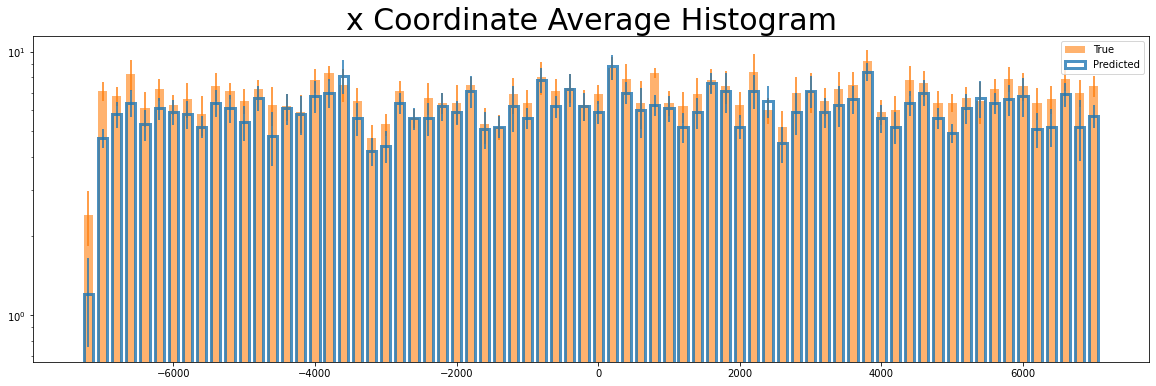

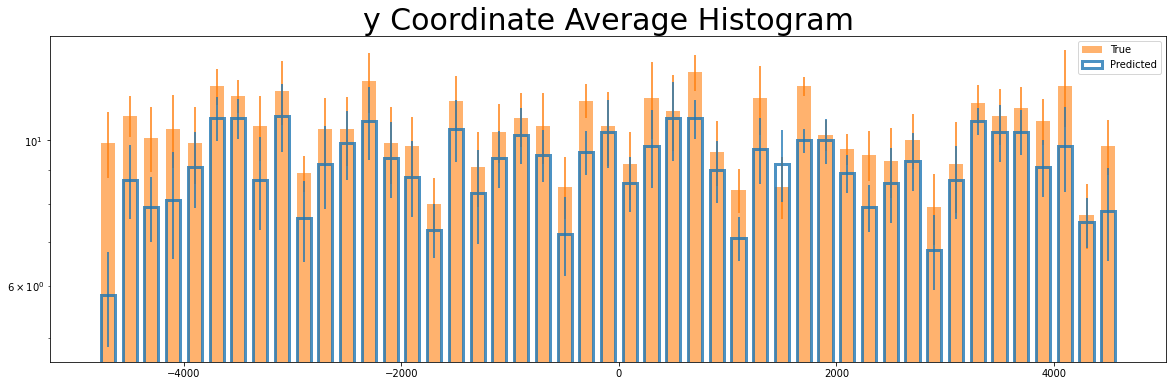

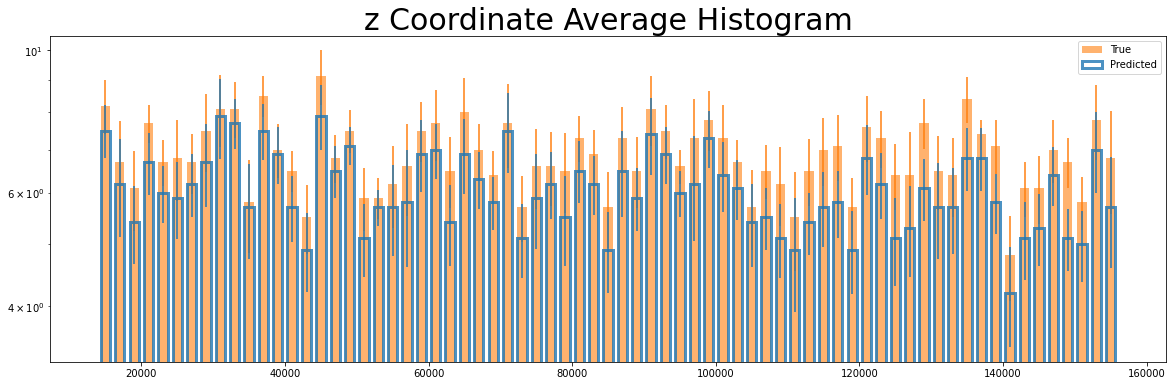

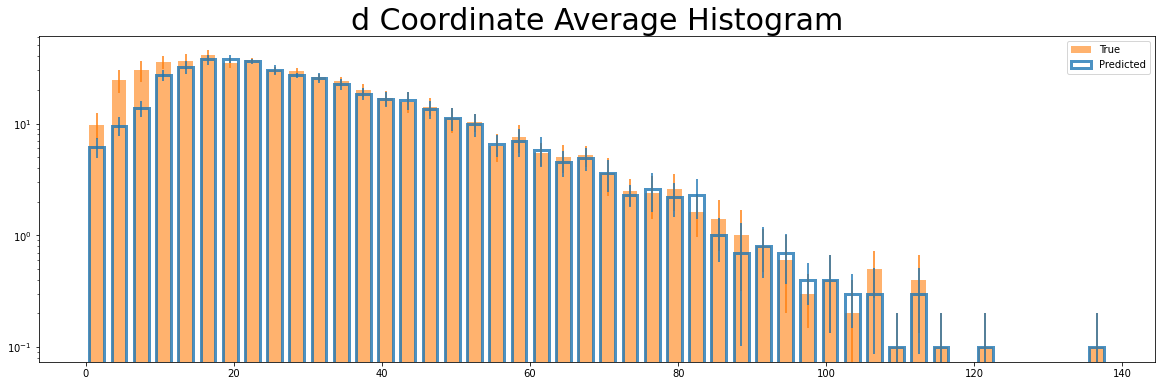

In [87]:
for coord in ['x', 'y', 'z', 'd']:
    plt.figure(figsize=(20,6))
    _, binEdges = np.histogram(particles[h_idx]['pred'][coord], bins=bins[coord])
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    plt.title(f"{coord} Coordinate Average Histogram", fontsize=30)
    plt.bar(bincenters, hist_avg['true'][f'{coord}_mean'], alpha=0.6, width=widths[coord], yerr=hist_avg['true'][f'{coord}_std'], label=true_label,
            color='#ff7f0e', ecolor='#ff7f0e')
    plt.bar(bincenters, hist_avg['pred'][f'{coord}_mean'], alpha=0.8, width=widths[coord], yerr=hist_avg['pred'][f'{coord}_std'], label='Predicted',
            fill=False, linewidth=3, edgecolor='#1f77b4', ecolor='#1f77b4')
    plt.legend()
    plt.savefig(f"{model_save}inference/{real}/hist_{coord}_avg.png")
    plt.yscale('log')
    plt.show()
    

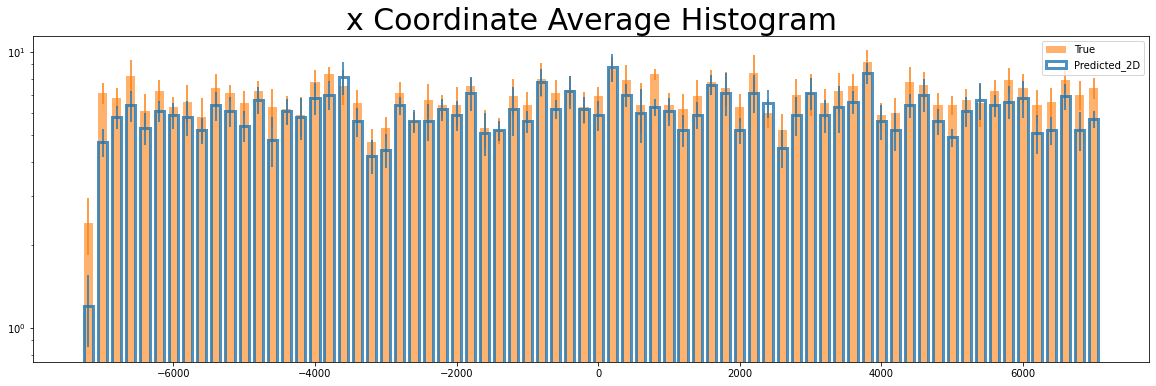

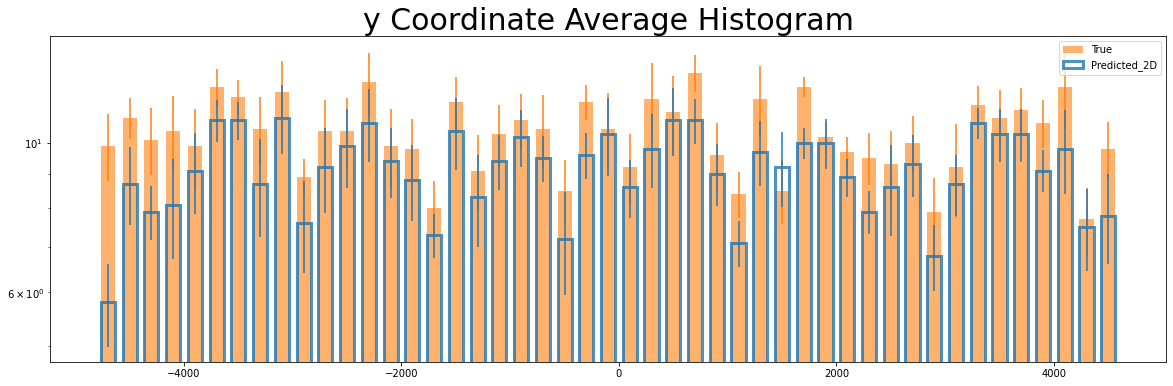

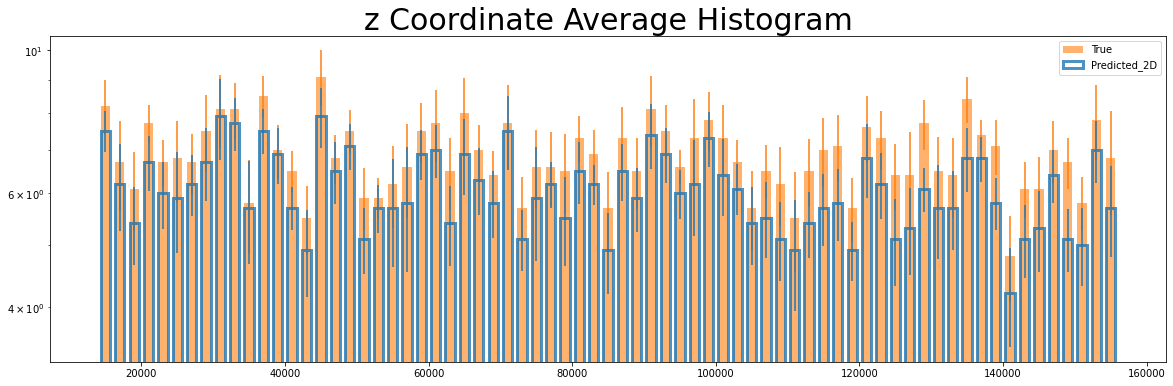

In [88]:
for coord in ['x', 'y', 'z']:
    plt.figure(figsize=(20,6))
    _, binEdges = np.histogram(particles[h_idx]['pred_2d'][coord], bins=bins[coord])
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    plt.title(f"{coord} Coordinate Average Histogram", fontsize=30)
    plt.bar(bincenters, hist_avg['true'][f'{coord}_mean'], alpha=0.6, width=widths[coord], yerr=hist_avg['true'][f'{coord}_std'], label=true_label,
            color='#ff7f0e', ecolor='#ff7f0e')
    plt.bar(bincenters, hist_avg['pred'][f'{coord}_mean'], alpha=0.8, width=widths[coord], yerr=hist_avg['pred_2d'][f'{coord}_std'], label='Predicted_2D',
            fill=False, linewidth=3, edgecolor='#1f77b4', ecolor='#1f77b4')
    plt.legend()
    plt.savefig(f"{model_save}inference/{real}/hist_{coord}_avg_2D.png")
    plt.yscale('log')
    plt.show()

### Histograms for individual holograms

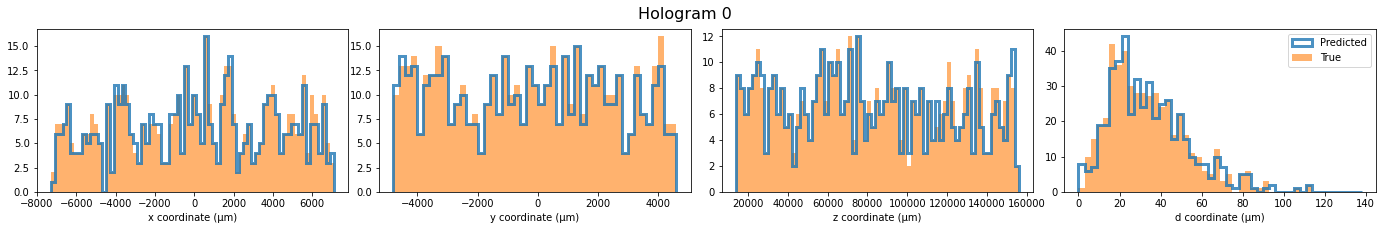

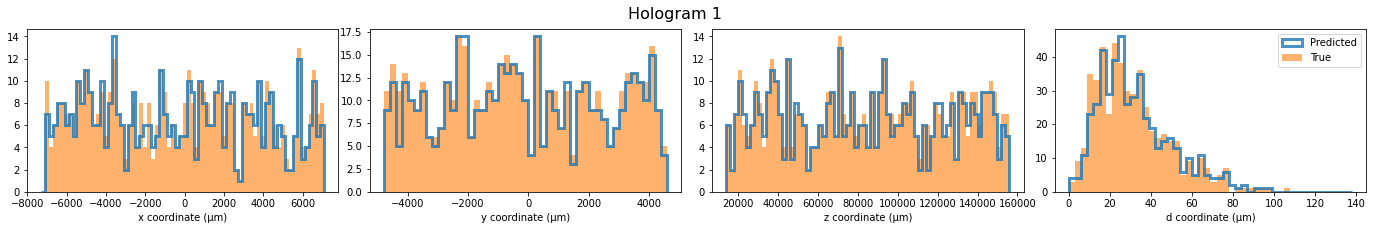

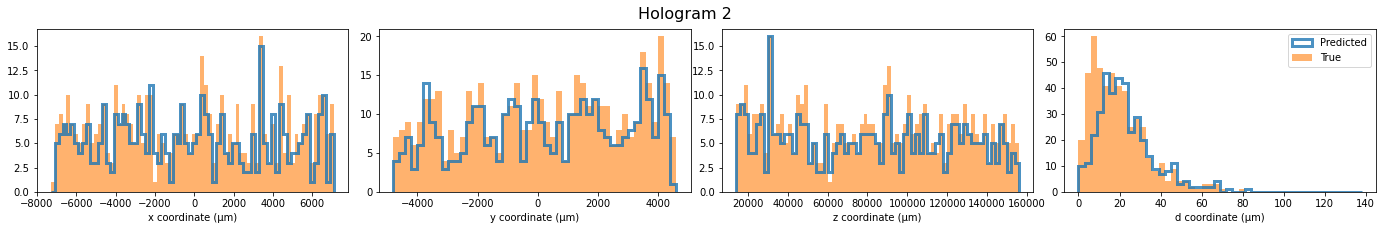

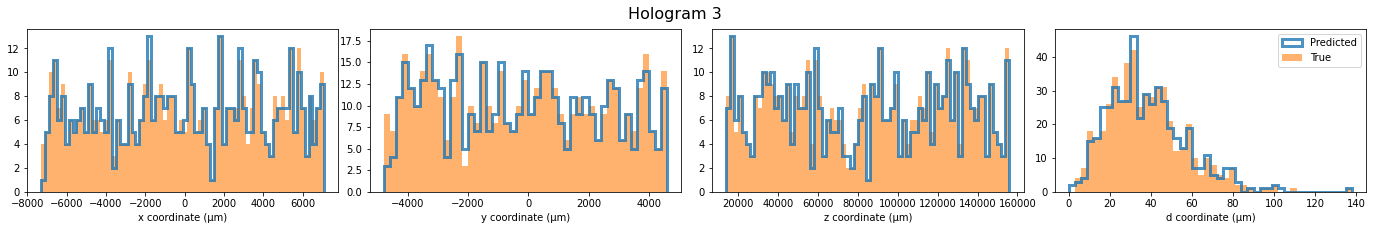

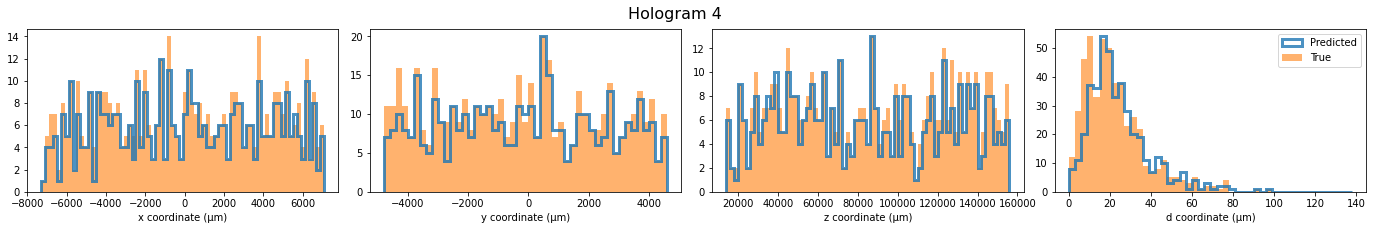

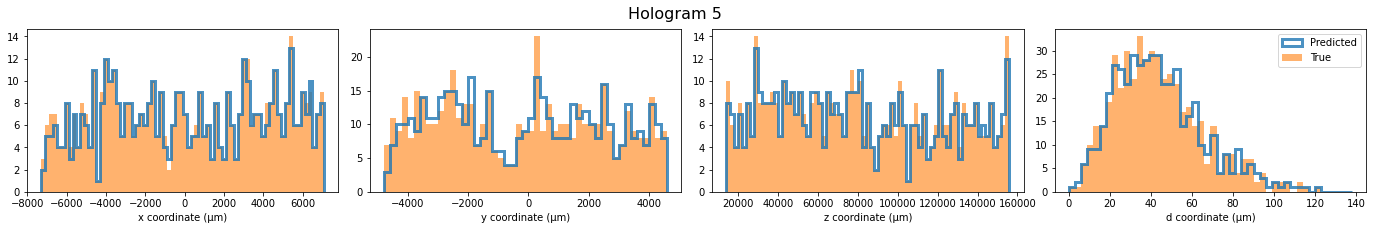

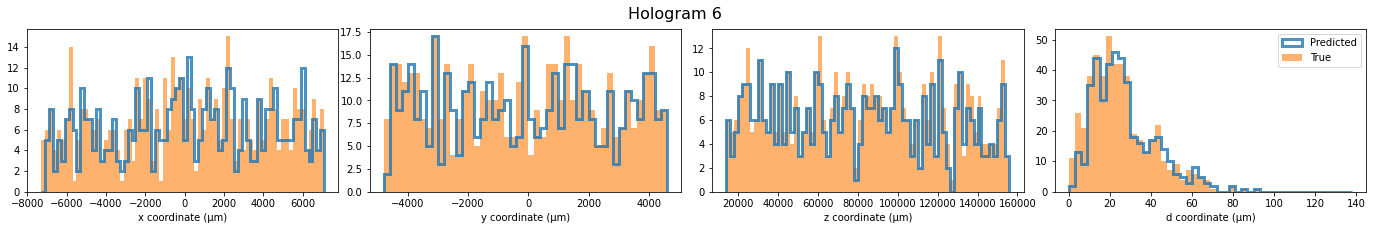

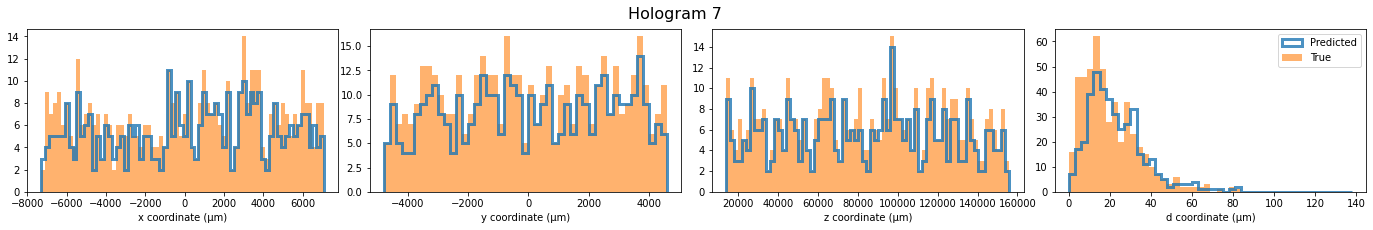

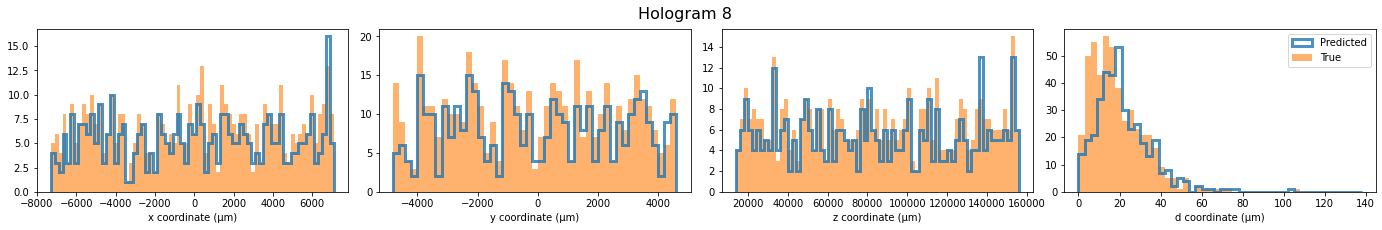

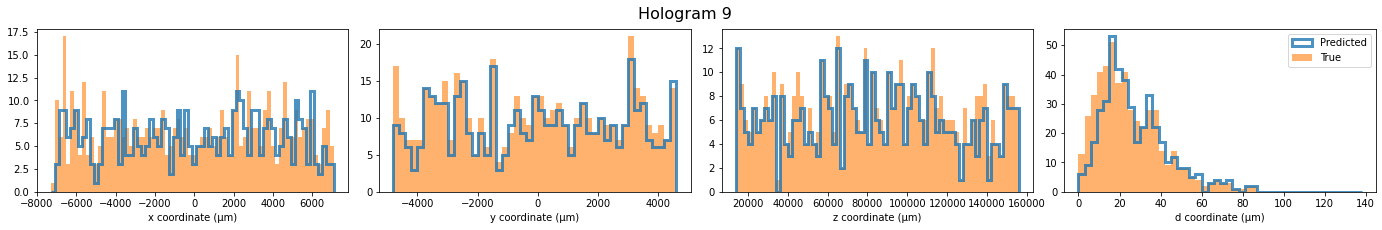

In [70]:
for h_idx in h_idx_indices:
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(24,3))
    fig.suptitle(f"Hologram {h_idx}", fontsize=16)
    for i, coord in enumerate(['x', 'y', 'z', 'd']):
        ax[i].hist(particles[h_idx]['pred'][coord], bins=bins[coord], alpha=0.8, label='Predicted', histtype='step', linewidth=3)
        ax[i].hist(particles[h_idx]['true'][coord], bins=bins[coord], alpha=0.6, label=true_label)
#         ax[i].hist(particles[h_idx]['orig'][coord], bins=bins[coord], alpha=0.6, label='Original')
        ax[i].set_xlabel(f"{coord} coordinate (µm)")
    plt.subplots_adjust(wspace=0.1)
    plt.legend()
    plt.show()
    fig.savefig(f"{model_save}inference/{real}/hist_{h_idx}.png", bbox_inches = "tight")


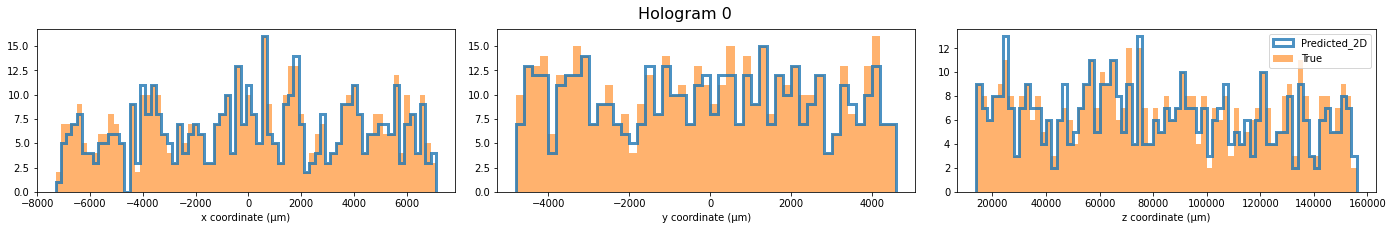

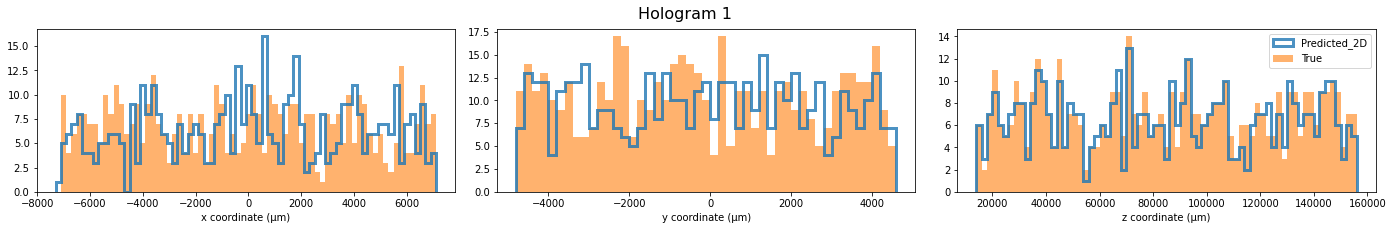

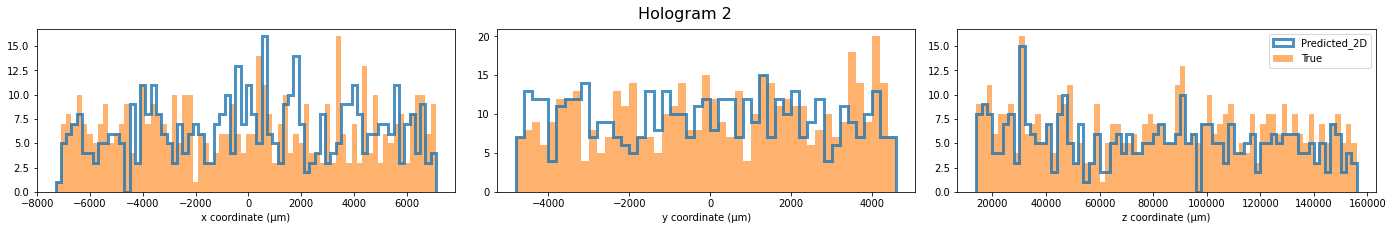

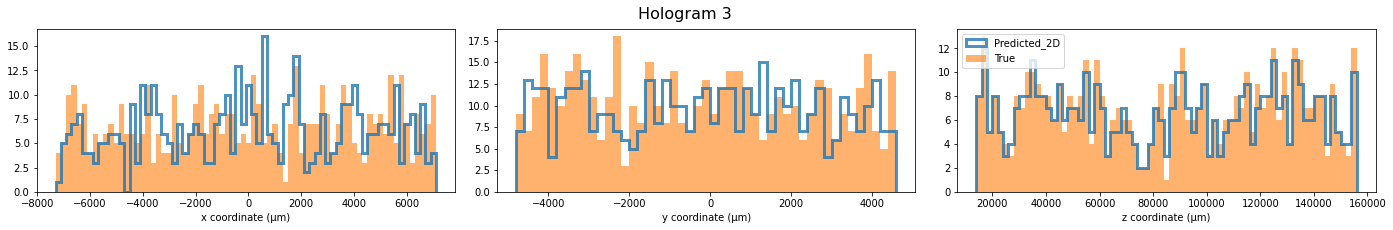

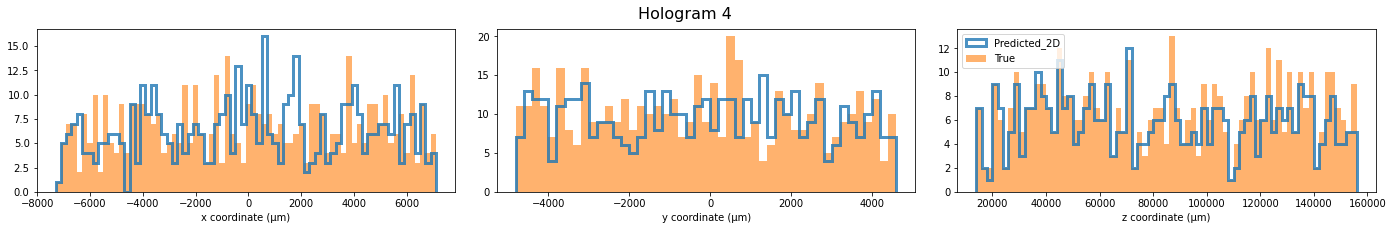

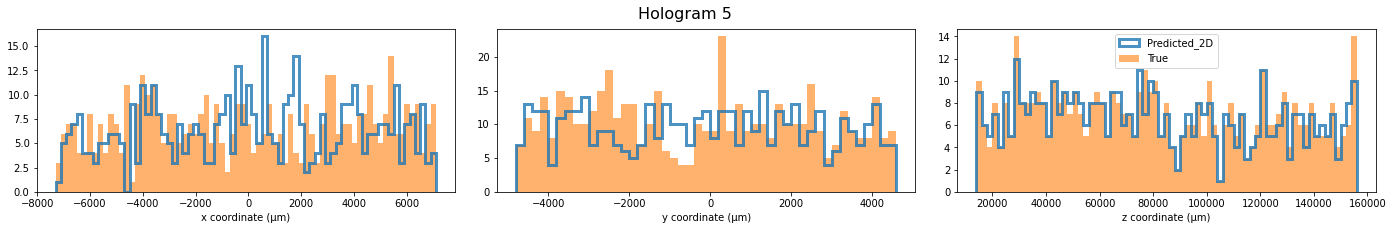

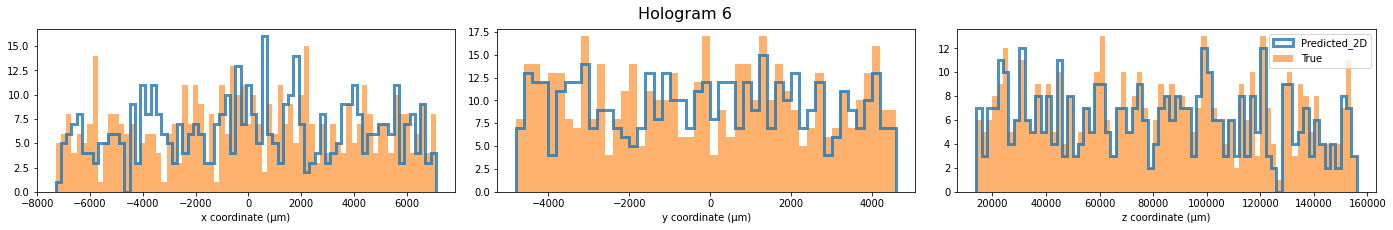

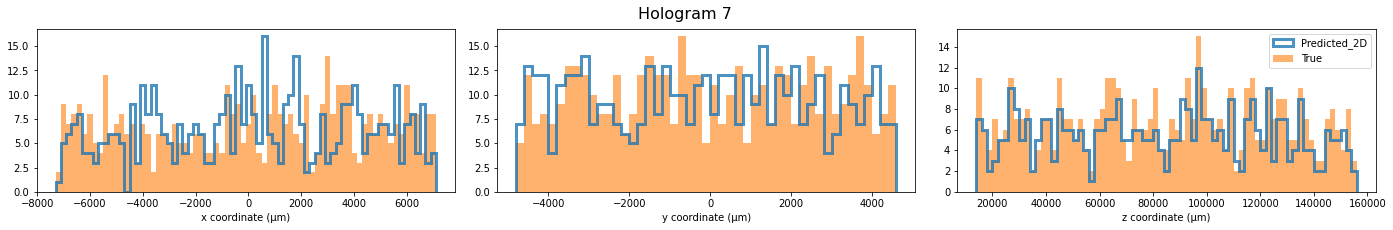

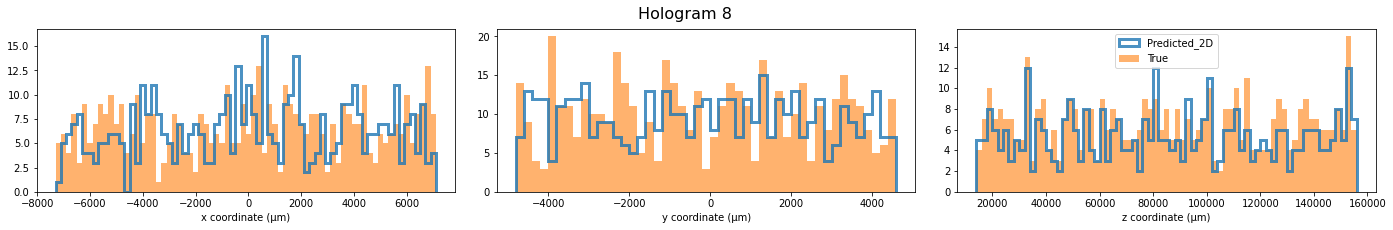

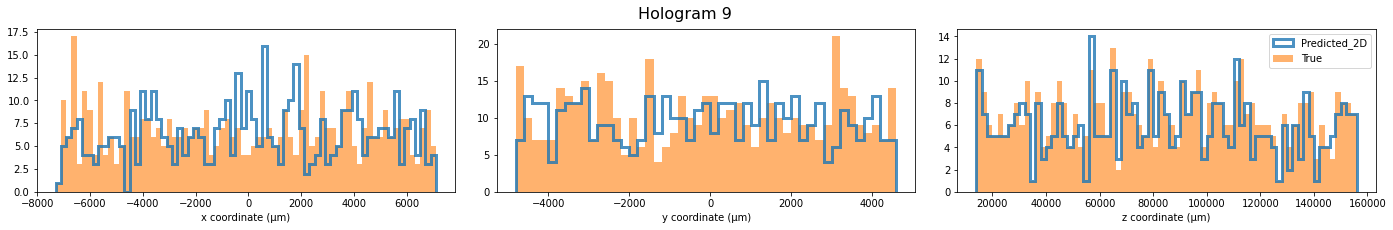

In [72]:
for h_idx in h_idx_indices:
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24,3))
    fig.suptitle(f"Hologram {h_idx}", fontsize=16)
    for i, coord in enumerate(['x', 'y', 'z']):
        ax[i].hist(particles[h_idx]['pred_2d'][coord], bins=bins[coord], alpha=0.8, label='Predicted_2D', histtype='step', linewidth=3)
        ax[i].hist(particles[h_idx]['true'][coord], bins=bins[coord], alpha=0.6, label=true_label)
#         ax[i].hist(particles[h_idx]['orig'][coord], bins=bins[coord], alpha=0.6, label='Original')
        ax[i].set_xlabel(f"{coord} coordinate (µm)")
    plt.subplots_adjust(wspace=0.1)
    plt.legend()
    plt.show()
    fig.savefig(f"{model_save}inference/{real}/hist_{h_idx}_2d.png", bbox_inches = "tight")


In [ ]:
f"{model_save}inference/{real}/hist_{h_idx}.png"

### Calculating the Z-Relative Mass


In [ ]:
z_bins = np.linspace(min(z_file_indices) - 100,
                     max(z_file_indices) + 100,
                     20)

z_mass_dict = {}
for true in ['true', 'pred']:
    z_mass = np.zeros((len(h_idx_indices), 20), dtype=np.float32)
    for i,h_idx in enumerate(h_idx_indices):
        for p in range(particles[h_idx][true]['z'].shape[0]):
            z_pos = np.searchsorted(z_bins, particles[h_idx][true]['z'][p], side="right") - 1
            mass = 4 / 3 * np.pi * (particles[h_idx][true]['d'][p]/2)**3
            z_mass[i, z_pos] += mass
    z_mass /= np.expand_dims(z_mass.sum(axis=1), -1)
    z_mass_dict[true] = z_mass


In [ ]:
plt.figure(figsize=(12,6))
plt.bar(z_bins / 1000, z_mass_dict['true'].mean(axis=0),
        (z_bins[1]-z_bins[0]) / 1000, color='#ff7f0e', alpha=0.6,
        label=true_label)
plt.bar(z_bins / 1000, z_mass_dict['pred'].mean(axis=0),
        (z_bins[1] - z_bins[0]) / 1000, edgecolor='#1f77b4', linewidth=3, alpha=0.8, facecolor="none", label='Predicted')
plt.xlabel("z location (mm)", fontsize=16)
plt.ylabel("Mean Mass Distribution", fontsize=16)
plt.legend(loc="best", fontsize=12)
plt.savefig(f"{model_save}inference/{real}/zmass_avg.png")
plt.show()


### 3D Visualizations

In [ ]:
for h_idx in h_idx_indices:
    for true in ['pred', 'true', 'orig']:
        data = [go.Scatter3d(x=particles[h_idx][true]['x'],
                     y=particles[h_idx][true]['y'],
                     z=particles[h_idx][true]['z'],
                     mode='markers',
                     marker=dict(size=particles[h_idx][true]['d']/2,
                                 color=particles[h_idx][true]['d'],
                                 colorscale='Rainbow',
                                 opacity=0.8),
                     text = [f"diameter: {d_i}" for d_i in particles[h_idx][true]['d']])]

        layout = go.Layout(title=f'{true_label} coordinates from scipy',
                           autosize=True,
                           width=700,
                           height=700,
                           margin=go.layout.Margin(
                                l=0,
                                r=0,
                                b=0,
                                t=40
                           )
                           )
        fig = go.Figure(data=data, layout=layout)
        fig.update_layout(hovermode="x",
                          scene_aspectmode='manual',
                          scene_aspectratio=dict(x=1, y=1, z=1))
        fig.write_image(f"{model_save}inference/{real}/3D_{h_idx}_{true}.png")
        fig.show()
        

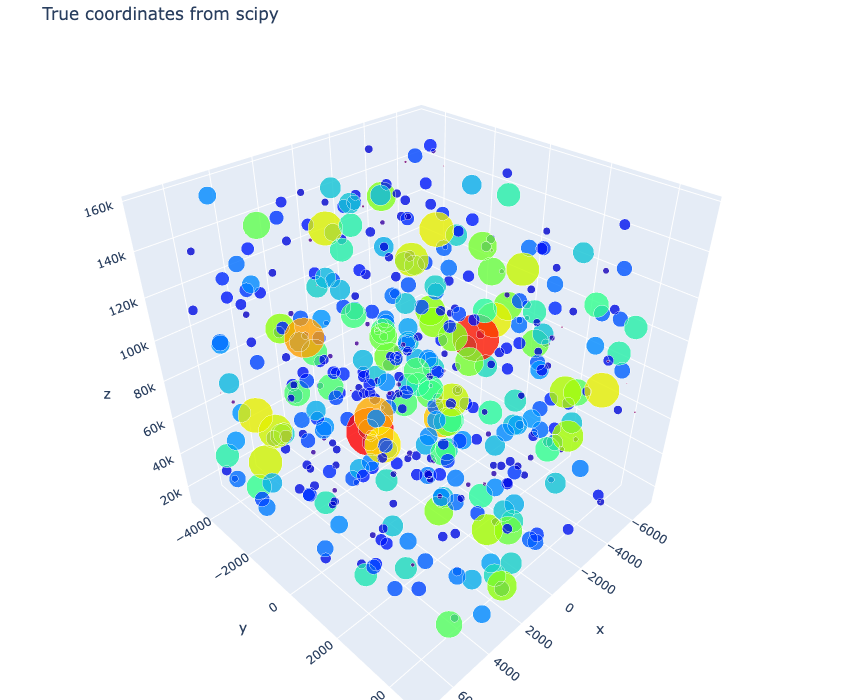

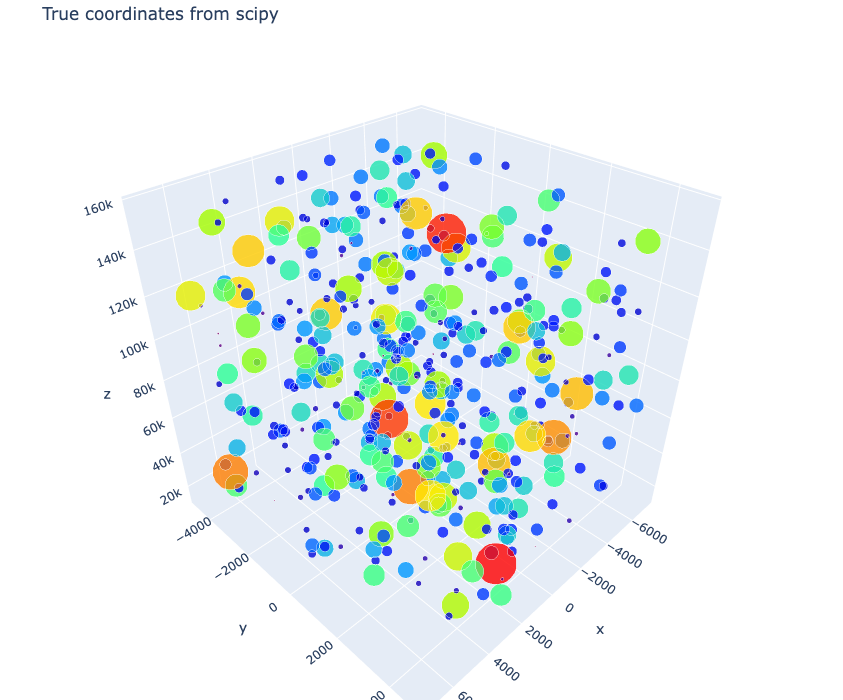

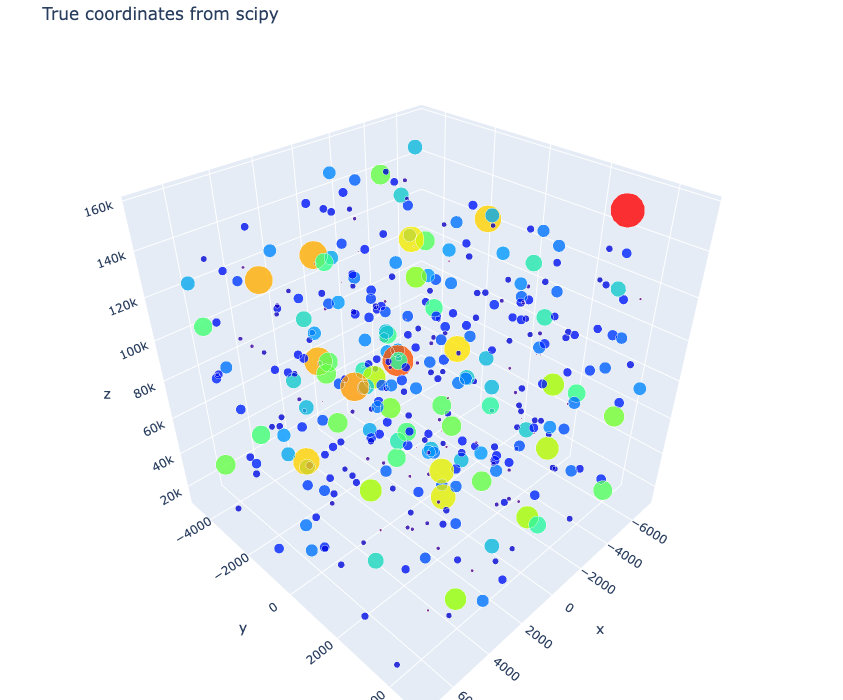

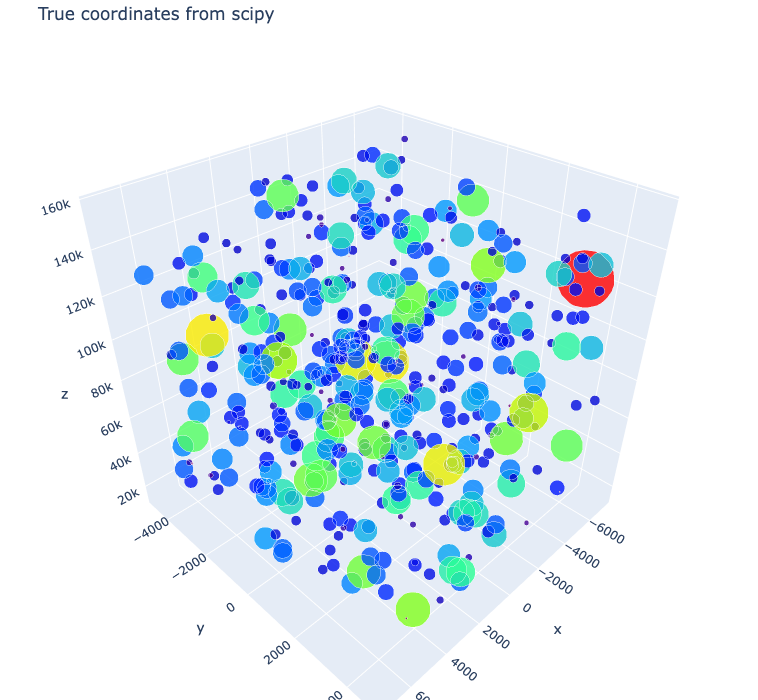

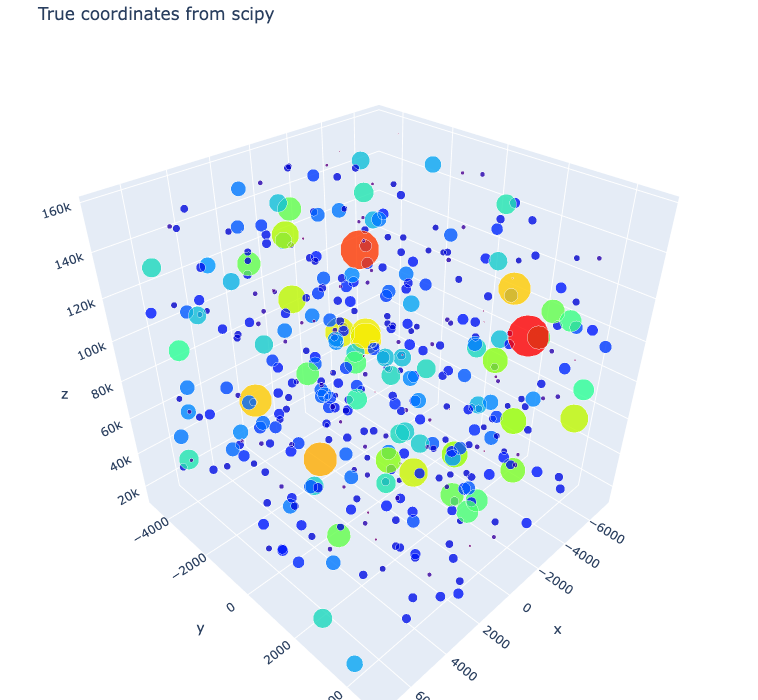

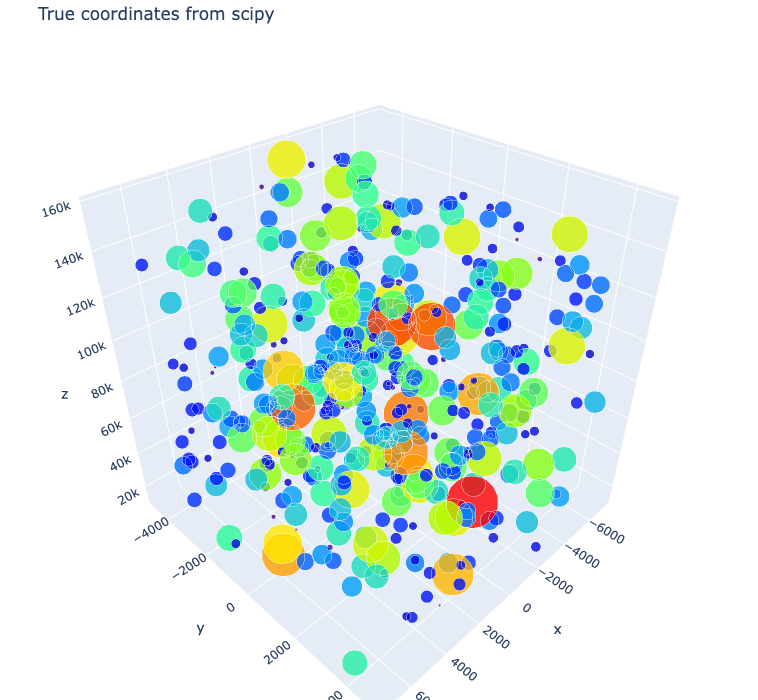

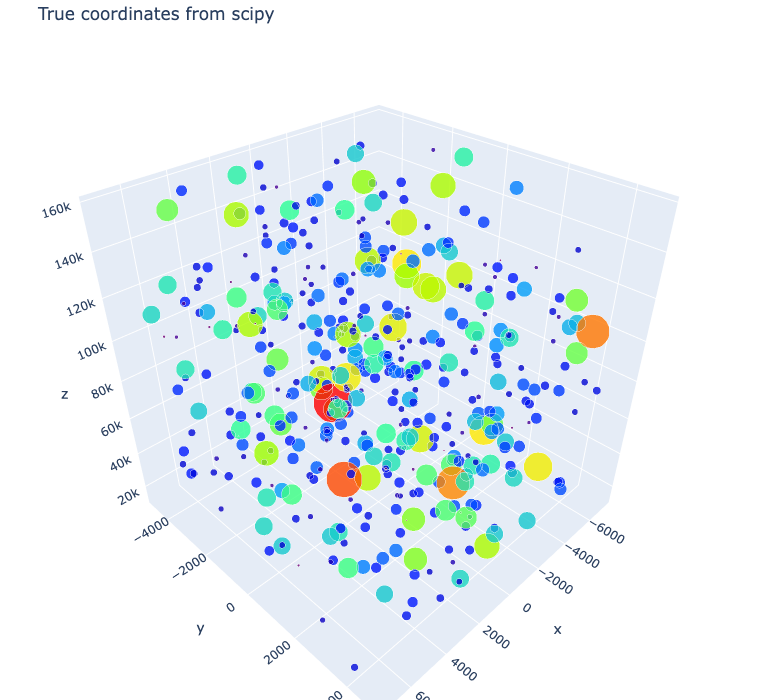

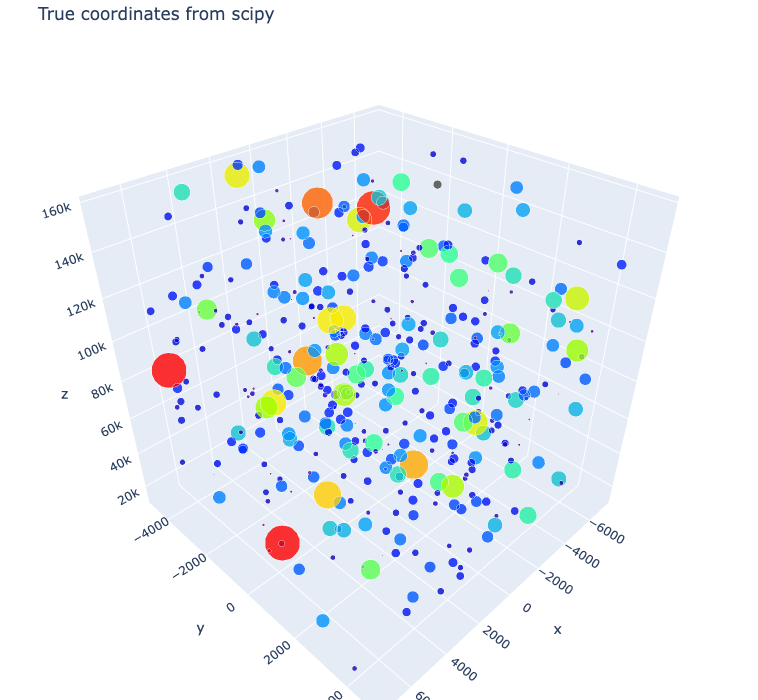

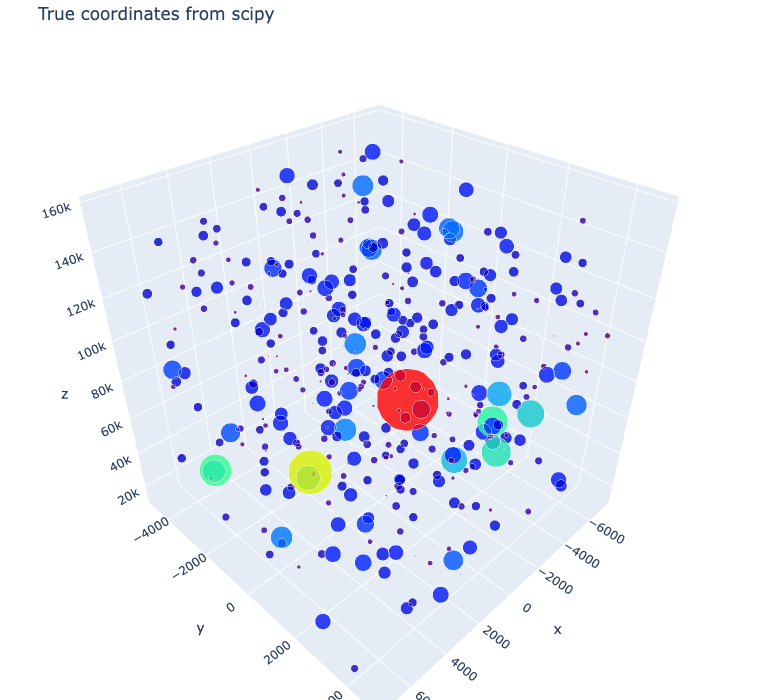

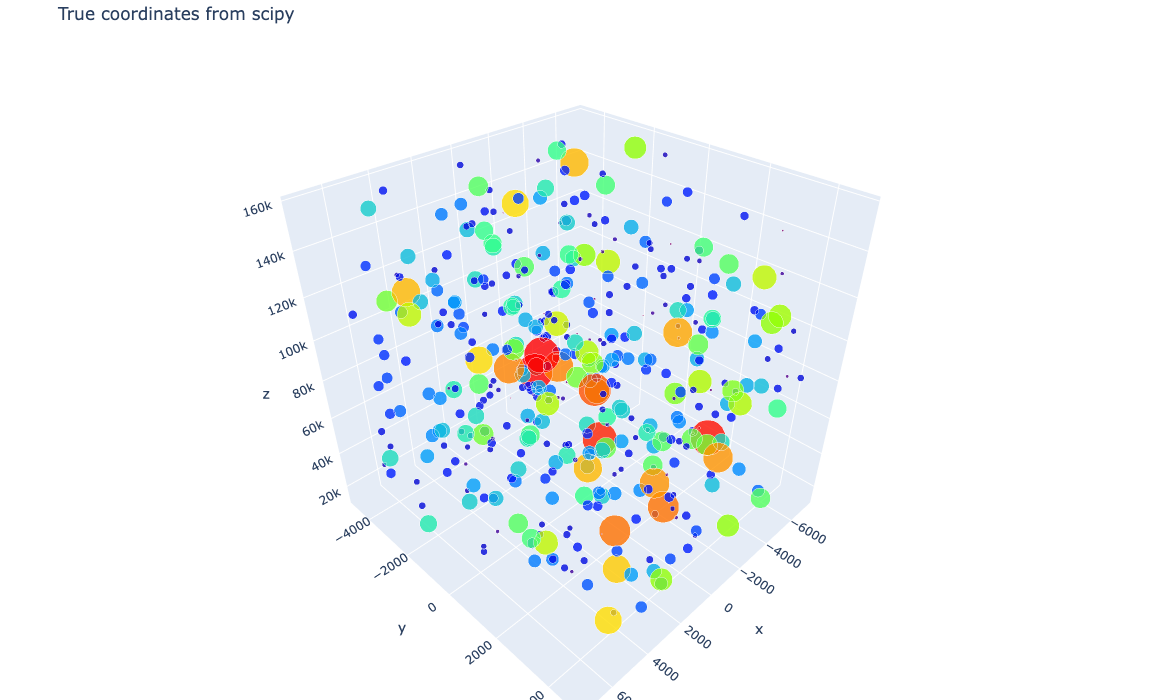

In [74]:
for h_idx in h_idx_indices:
    for true in ['pred_2d']:
        data = [go.Scatter3d(x=particles[h_idx][true]['x'],
                     y=particles[h_idx][true]['y'],
                     z=particles[h_idx][true]['z'],
                     mode='markers',
                     marker=dict(size=particles[h_idx][true]['d']/2,
                                 color=particles[h_idx][true]['d'],
                                 colorscale='Rainbow',
                                 opacity=0.8),
                     text = [f"diameter: {d_i}" for d_i in particles[h_idx][true]['d']])]

        layout = go.Layout(title=f'{true_label} coordinates from scipy',
                           autosize=True,
                           width=700,
                           height=700,
                           margin=go.layout.Margin(
                                l=0,
                                r=0,
                                b=0,
                                t=40
                           )
                           )
        fig = go.Figure(data=data, layout=layout)
        fig.update_layout(hovermode="x",
                          scene_aspectmode='manual',
                          scene_aspectratio=dict(x=1, y=1, z=1))
        fig.write_image(f"{model_save}inference/{real}/3D_{h_idx}_{true}.png")
        fig.show()
        

## Calculating Particle Distance and MAE

In [ ]:
for h_idx in h_idx_indices:
    print(h_idx)
    plt.figure(figsize=(12, 24))
    plt.imshow(ds['image'][h_idx].T)
    plt.show()

### Calculating Particle Distance and MAE


<!-- ### Calculating the Euclidian Distance -->

In [ ]:
def normalize(x):
    return (x - x.min()) / (x.max() - x.min())


In [ ]:
maes = {}

for true in ['true', 'orig']:
    maes[true] = {}
    for h_idx in h_idx_indices:
        maes[true][h_idx] = {}
        mae = np.zeros((particles[h_idx]['pred']['x'].shape[0], particles[h_idx][true]['x'].shape[0]))
        for coord in ['x', 'y', 'z']:
            mae += np.abs(normalize(particles[h_idx]['pred'][coord]).reshape(-1,1) - normalize(particles[h_idx][true][coord]).reshape(1,-1))
        maes[true][h_idx]['no_diam'] = np.copy(mae)
        mae += np.abs(normalize(particles[h_idx]['pred']['d']).reshape(-1,1) - normalize(particles[h_idx][true]['d']).reshape(1,-1))
        maes[true][h_idx]['with_diam'] = mae

with open(f"{model_save}inference/{real}/maes.pkl", 'wb') as handle:
    pickle.dump(maes, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

In [ ]:
with open(f"{model_save}inference/{real}/maes.pkl", "rb") as input_file:
    maes = pickle.load(input_file)

In [ ]:
distances = {}

for true in ['true', 'orig']:
    distances[true] = {}
    for h_idx in h_idx_indices:
        distances[true][h_idx] = {}
        dist = np.zeros((particles[h_idx]['pred']['x'].shape[0], particles[h_idx][true]['x'].shape[0]))
        for coord in ['x', 'y', 'z']:
            dist += (normalize(particles[h_idx]['pred'][coord]).reshape(-1,1) - normalize(particles[h_idx][true][coord]).reshape(1,-1)) ** 2
        distances[true][h_idx]['no_diam'] = np.copy(dist)
        dist += (normalize(particles[h_idx]['pred']['d']).reshape(-1,1) - normalize(particles[h_idx][true]['d']).reshape(1,-1)) ** 2
        distances[true][h_idx]['with_diam'] = dist

with open(f"{model_save}inference/{real}/distances.pkl", 'wb') as handle:
    pickle.dump(distances, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
with open(f"{model_save}inference/{real}/distances.pkl", "rb") as input_file:
    distances = pickle.load(input_file)

### Using MunkRes (with and without diameters)

In [ ]:
pairs = {}

for true in ['true', 'orig']:
    pairs[true] = {}
    for h_idx in h_idx_indices:
        pairs[true][h_idx] = {}
        for diam in ['with_diam', 'no_diam']:
            pairs[true][h_idx][diam] = {}
            distance = np.copy(distances[true][h_idx][diam])
            start_munkres = datetime.now()
            m = Munkres()
            if distance.shape[0] > distance.shape[1]:
                distance = np.swapaxes(distance, 0, 1)
                indexes = m.compute(distance)
                indexes = [tuple((i[1], i[0])) for i in indexes]
                pairs[true][h_idx][diam]['indexes'] = indexes
            else:
                pairs[true][h_idx][diam]['indexes'] = m.compute(distance)
            print('___________________________________________________________________________________________')
            print(f"Munkres for {true} {h_idx} took {datetime.now() - start_munkres} time")
            print(f"{distance.shape[0]} predicted particles paired with {len(list(set([i[1] for i in pairs[true][h_idx][diam]['indexes']])))} unique true particles.")

            ds = []
            ms = []
            for row, column in pairs[true][h_idx][diam]['indexes']:
                ds.append(distances[true][h_idx][diam][row][column])
                ms.append(maes[true][h_idx][diam][row][column])
            pairs[true][h_idx][diam]['distances'] = np.array(ds)
            pairs[true][h_idx][diam]['maes'] = np.array(ms)
            print(f"Total Distance for Hologram {h_idx} predicted vs {true} and {diam} = {np.sum(pairs[true][h_idx][diam]['distances'])}")
            print(f"Total MAE for Hologram {h_idx} predicted vs {true} and {diam} = {np.sum(pairs[true][h_idx][diam]['maes'])}\n")

with open(f"{model_save}inference/{real}/pairs.pkl", 'wb') as handle:
    pickle.dump(pairs, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
with open(f"{model_save}inference/{real}/pairs.pkl", "rb") as input_file:
    pairs = pickle.load(input_file)

In [ ]:
for true in ['true', 'orig']:
    for h_idx in h_idx_indices:
        for diam in ['with_diam', 'no_diam']:
            print('___________________________________________________________________________________________')
            print(f"{distances[true][h_idx][diam].shape[0]} predicted particles paired with {len(list(set([i[1] for i in pairs[true][h_idx][diam]['indexes']])))} unique true particles.")
            print(f"Total Distance for Hologram {h_idx} predicted vs {true} and {diam} = {np.sum(pairs[true][h_idx][diam]['distances']):.3f}")
            print(f"Total MAE for Hologram {h_idx} predicted vs {true} and {diam} = {np.sum(pairs[true][h_idx][diam]['maes']):.2f}\n")


In [ ]:
for h_idx in h_idx_indices:
    for diam in ['with_diam', 'no_diam']:
        for m in ['min', 'max']:
            if m == 'min':
                pred_idx = int(np.where(pairs["true"][h_idx][diam]['distances'] == min(pairs["true"][h_idx][diam]['distances']))[0])
            if m == 'max':
                pred_idx = int(np.where(pairs["true"][h_idx][diam]['distances'] == max(pairs["true"][h_idx][diam]['distances']))[0])
            data = [go.Scatter3d(x=[particles[h_idx]['pred']['x'][pred_idx]],
                     y=[particles[h_idx]['pred']['y'][pred_idx]],
                     z=[particles[h_idx]['pred']['z'][pred_idx]],
                     mode='markers',
                     marker=dict(size=[particles[h_idx]['pred']['d'][pred_idx]],
                                 color='rgb(150,0,90)',
                                 opacity=0.8),
                     text = f"diameter: {particles[h_idx]['pred']['d'][pred_idx]:.2f}",
                     name="Predicted")]

            layout = go.Layout(title=f'''Comparison of predicted particle for {diam} hologram {h_idx} and {m} distance<br>
            Pred: {particles[h_idx]['pred']['x'][pred_idx]:.1f},
             {particles[h_idx]['pred']['y'][pred_idx]:.1f},
             {particles[h_idx]['pred']['z'][pred_idx]:.0f},
             {particles[h_idx]['pred']['d'][pred_idx]:.2f}<br>
            True: {particles[h_idx]['true']['x'][pairs['true'][h_idx][diam]['indexes'][pred_idx][1]]:.1f},
             {particles[h_idx]['true']['y'][pairs['true'][h_idx][diam]['indexes'][pred_idx][1]]:.1f},
             {particles[h_idx]['true']['z'][pairs['true'][h_idx][diam]['indexes'][pred_idx][1]]:.0f},
             {particles[h_idx]['true']['d'][pairs['true'][h_idx][diam]['indexes'][pred_idx][1]]:.2f}<br>
            Orig: {particles[h_idx]['orig']['x'][pairs['orig'][h_idx][diam]['indexes'][pred_idx][1]]:.1f},
             {particles[h_idx]['orig']['y'][pairs['orig'][h_idx][diam]['indexes'][pred_idx][1]]:.1f},
             {particles[h_idx]['orig']['z'][pairs['orig'][h_idx][diam]['indexes'][pred_idx][1]]:.0f},
             {particles[h_idx]['orig']['d'][pairs['orig'][h_idx][diam]['indexes'][pred_idx][1]]:.2f}<br>
            MAE true: {maes['true'][h_idx][diam][pred_idx][pairs['true'][h_idx][diam]['indexes'][pred_idx][1]]:.4f}<br>
            MAE orig: {maes['orig'][h_idx][diam][pred_idx][pairs['orig'][h_idx][diam]['indexes'][pred_idx][1]]:.4f}''',
                               width=700,
                               height=700,
                               margin=go.layout.Margin(
                                    l=0,
                                    r=0,
                                    b=0,
                                    t=40))
            
            fig = go.Figure(data=data, layout=layout)
            fig.add_trace(go.Scatter3d(x=[particles[h_idx]['true']['x'][pairs['true'][h_idx][diam]['indexes'][pred_idx][1]]],
                                 y=[particles[h_idx]['true']['y'][pairs['true'][h_idx][diam]['indexes'][pred_idx][1]]],
                                 z=[particles[h_idx]['true']['z'][pairs['true'][h_idx][diam]['indexes'][pred_idx][1]]],
                                 mode='markers',
                                 marker=dict(size=[particles[h_idx]['true']['d'][pairs['true'][h_idx][diam]['indexes'][pred_idx][1]]],
                                             color='rgb(0,0,200)',
                                             opacity=0.8),
                                 text = f"diameter: {particles[h_idx]['true']['d'][pairs['true'][h_idx][diam]['indexes'][pred_idx][1]]:.2f}",
                                 name = "True"))
            fig.add_trace(go.Scatter3d(x=[particles[h_idx]['orig']['x'][pairs['orig'][h_idx][diam]['indexes'][pred_idx][1]]],
                                 y=[particles[h_idx]['orig']['y'][pairs['orig'][h_idx][diam]['indexes'][pred_idx][1]]],
                                 z=[particles[h_idx]['orig']['z'][pairs['orig'][h_idx][diam]['indexes'][pred_idx][1]]],
                                 mode='markers',
                                 marker=dict(size=[particles[h_idx]['orig']['d'][pairs['orig'][h_idx][diam]['indexes'][pred_idx][1]]],
                                             color='rgb(151,255,0)',
                                             opacity=0.8),
                                 text = f"diameter: {particles[h_idx]['orig']['d'][pairs['orig'][h_idx][diam]['indexes'][pred_idx][1]]:.2f}",
                                 name = "Original"))

            fig.update_layout(hovermode="x",
                              scene_aspectmode='manual',
                              scene_aspectratio=dict(x=1, y=1, z=1),
                              scene = dict(xaxis = dict(nticks=6, range=[-7300, 7300]),
                                           yaxis = dict(nticks=6, range=[-4800, 4800]),
                                           zaxis = dict(nticks=6, range=[14000, 158000])))

            fig.write_image(f"{model_save}inference/{real}/3D_{h_idx}_{diam}_{m}.png")
            fig.show()
